In [75]:
# Parameters
symbol = '^GSPC'
start_date = '1970'

### Chiao Cheng <chiaolun@gmail.com>
### Inspirations
* https://theirrelevantinvestor.com/2019/02/08/miss-the-worst-days-miss-the-best-days/
* https://awealthofcommonsense.com/2020/03/what-if-you-buy-stocks-too-early-during-a-market-crash/
* https://awealthofcommonsense.com/2020/04/would-you-rather-buy-too-early-or-buy-too-late-in-a-bear-market/
* https://mebfaber.com/2019/11/04/is-buying-stocks-at-an-all-time-high-a-good-idea/

In [76]:
%matplotlib inline

In [77]:
import pandas as pd
import numpy as np
import yfinance as yf

import numba
from scipy.optimize import minimize

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import set_matplotlib_formats

# set_matplotlib_formats('svg')
mpl.rcParams['figure.figsize'] = [16, 12]

In [78]:
data = yf.Ticker(symbol).history(period='max', auto_adjust=True)[start_date:]

In [79]:
# Note that when using ^GSPC, there are no dividends, and it's also 
# not really directly tradeable - I'll do a continuous futures version 
# at some point

# Rest of analysis assumes non-stock allocation is in cash, 
# but in reality you would have some gains from being in bonds as well

# We add transaction costs further down this sheet

rets = data['Close'].transform(lambda xs: xs / xs.shift() - 1).rename('rets')
ma200 = data.Close.rolling(200).mean()

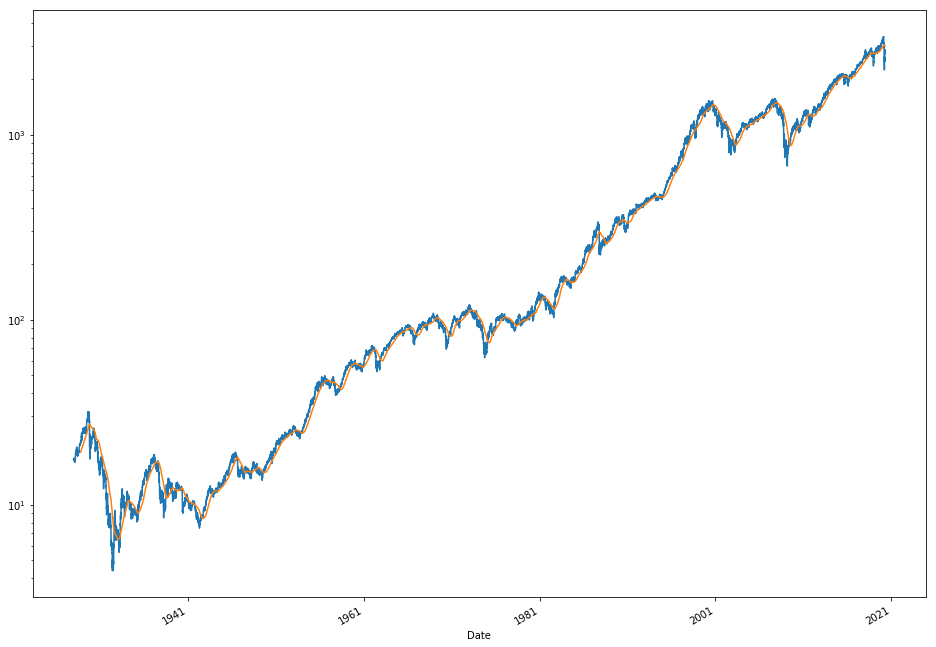

In [80]:
# The 200-day moving average (MA200) is a lagging, smoother version of the original data
data.Close.plot(logy=True)
ma200.plot(logy=True);

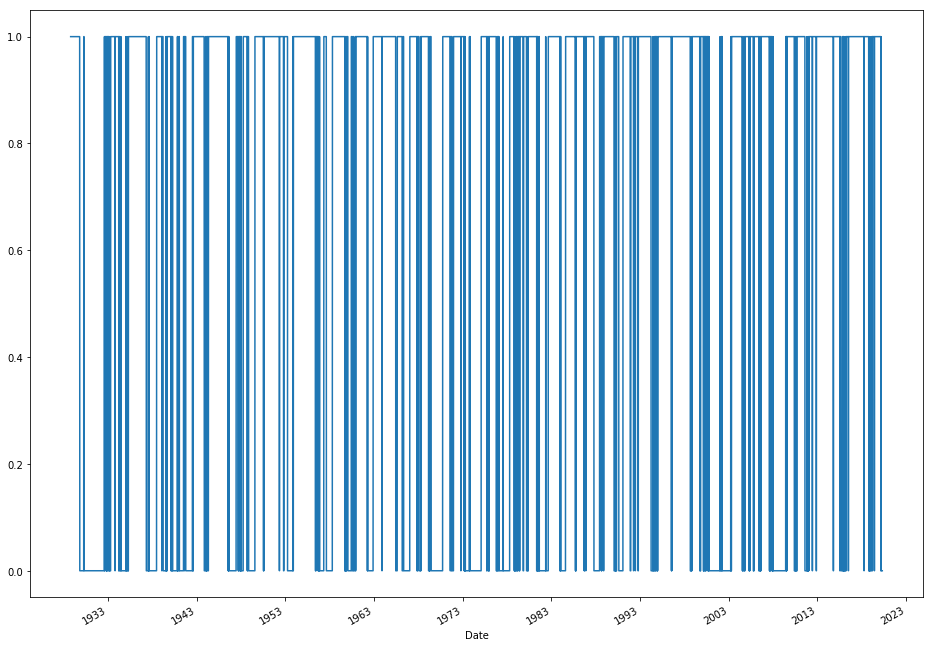

In [81]:
# It can be used for betting on momentum, doing market timing by being long when the close is above the MA200
position = (data.Close > ma200).astype(int)
position[ma200.isnull()] = np.nan
position = position.shift()  # Delay by one day
position.plot()

In [82]:
strats = pd.DataFrame({
    'buy_and_hold': 1, 
    'ma200': position
})

In [83]:
def plot_dd(rets):
    c_pl = rets.add(1).cumprod()

    c_pl.plot(lw=1, color='black', logy=True)
    plt.fill_between(
        c_pl.index,
        c_pl,
        c_pl.cummax(),
        facecolor='red',
        alpha=0.5,
    )

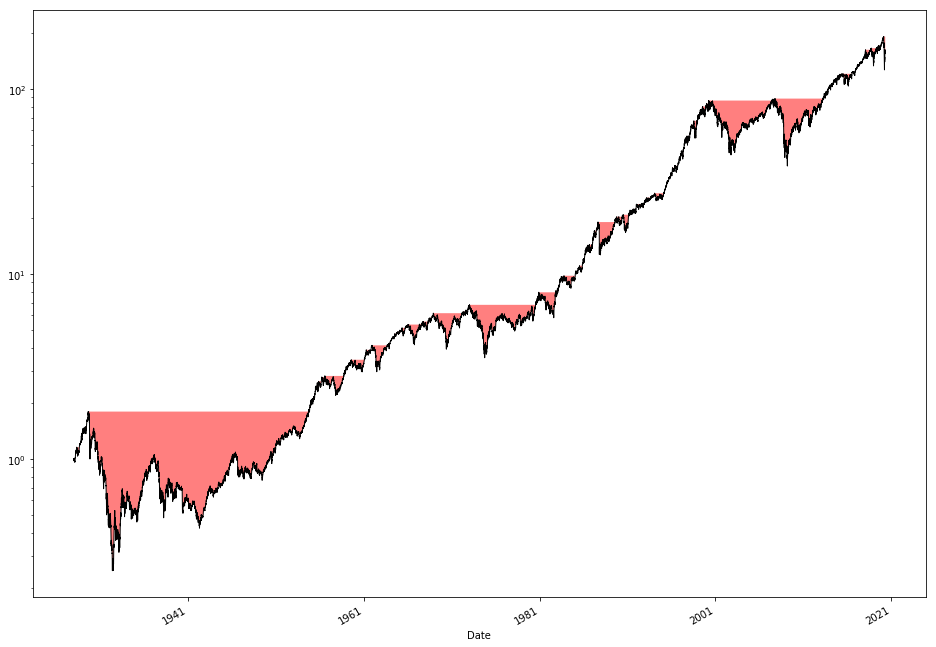

In [84]:
# This is the plain old SP500
plot_dd(strats.buy_and_hold.mul(rets, axis=0))

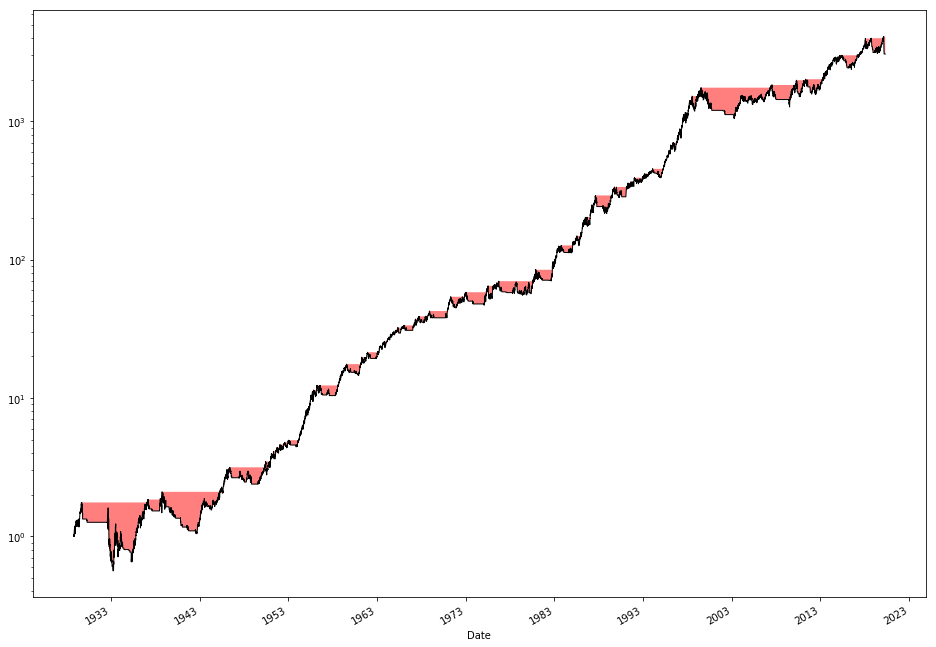

In [85]:
# This is with the MA200 crossover timing - the returns are lower but drawdowns are less deep
plot_dd(strats.ma200.mul(rets, axis=0))

In [86]:
# Slightly worse returns
strats.mul(rets, axis=0).add(1).apply(np.log).mean().mul(250).apply(np.exp).sub(1)

buy_and_hold    0.056290
ma200           0.091255
dtype: float64

In [87]:
# Better worst and average drawdown
(
    strats.mul(rets, axis=0)
    .add(1).cumprod()
    .transform(lambda xs: xs / xs.cummax() - 1)
    .agg(['min', 'mean'])
    .T
)

,min,mean
buy_and_hold,-0.861896,-0.216287
ma200,-0.679417,-0.136640


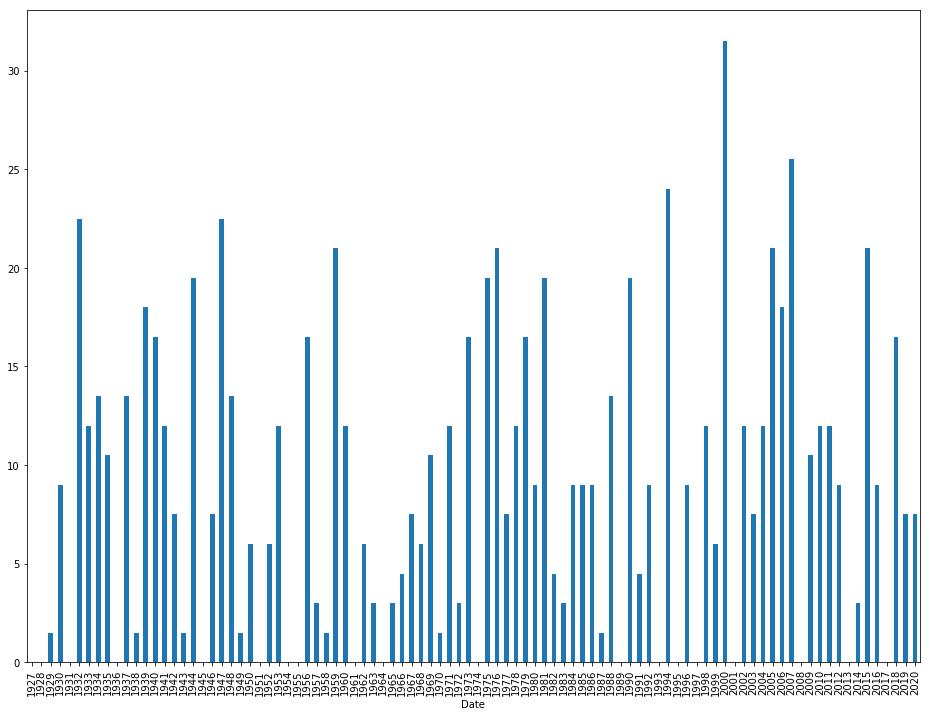

In [88]:
# These results are all before accounting for trading costs!
# Turnover can be awfully high - 20x in some years! You are trading in and out of the market a lot
# Some concerns about overfitting due to sensitivity to exactly when the crossings happen
(
    strats.ma200.diff().abs()
    .groupby(pd.Grouper(freq='Y')).sum()
    .rename(index=lambda xs: xs.year)
    .plot.bar()
)

In [89]:
# Let's smoothen the signal by acting slowly on it!
@numba.njit
def _smoothen(signal, nsteps):
    pos = np.zeros_like(signal, dtype=np.float64)
    pos[0] = 1.
    for i in range(1, pos.shape[0]):
        if signal[i] > pos[i - 1] + 1e-5:
            d = 1. / nsteps
        elif signal[i] < pos[i - 1] - 1e-5:
            d = -1. / nsteps
        else:
            d = 0
        pos[i] = pos[i - 1] + d
    return pos


def smoothen(signal, nsteps):
    return pd.Series(
        _smoothen(signal.values, nsteps),
        index=signal.index
    )

In [90]:
strats['ma200_slow'] = smoothen(strats.ma200, 90)

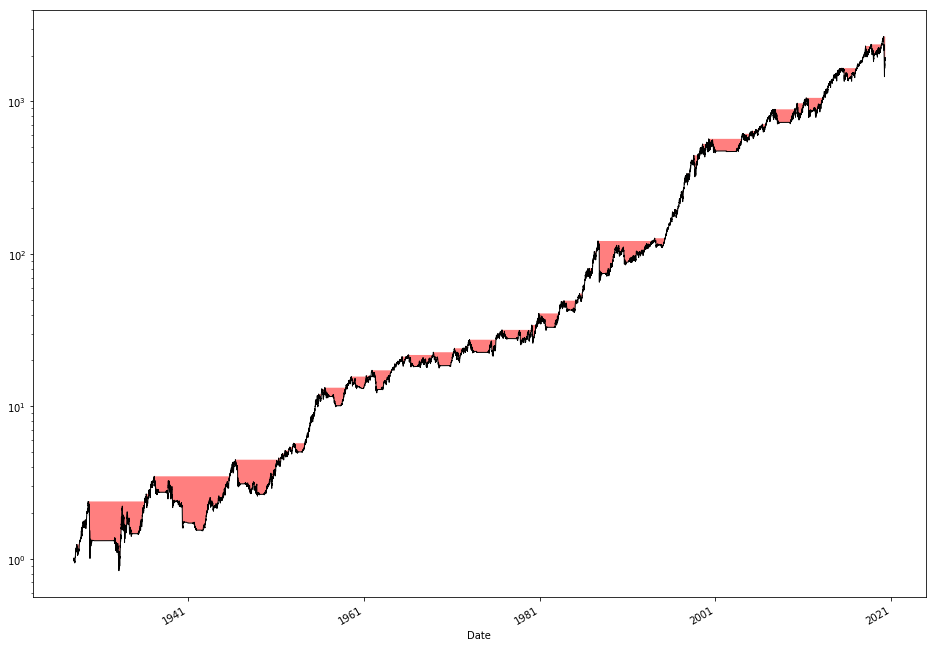

In [91]:
# Smoothed MA200 crossover
plot_dd(strats.ma200_slow * rets)

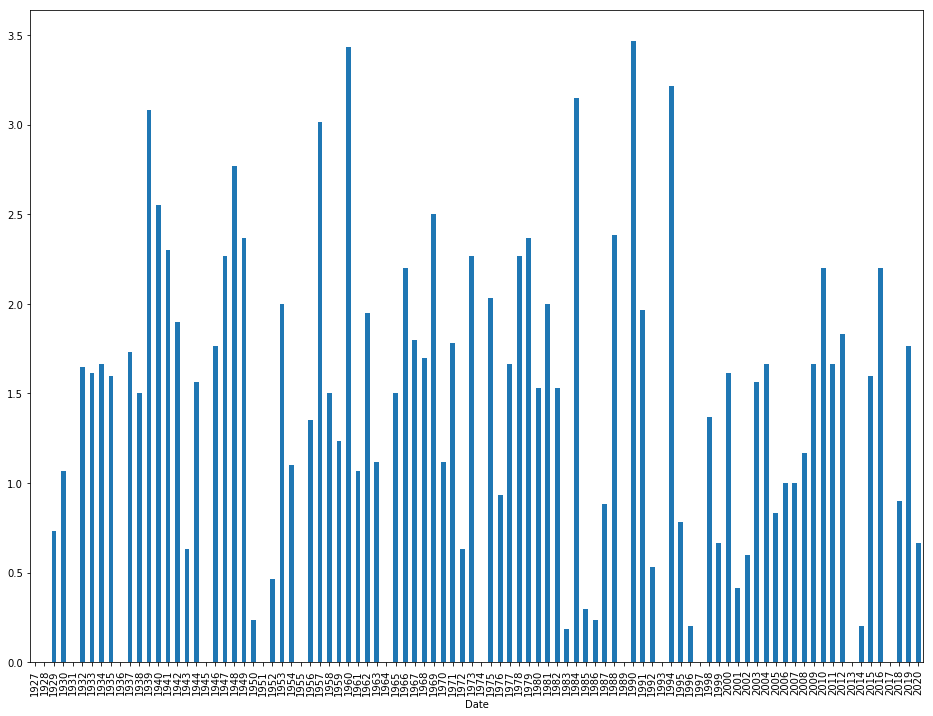

In [92]:
# Turnover is way down
(
    strats.ma200_slow.diff().abs()
    .groupby(pd.Grouper(freq='Y')).sum()
    .rename(index=lambda xs: xs.year)
    .plot.bar()
)

In [93]:
# Average annual returns
strats.mul(rets, axis=0).add(1).apply(np.log).mean().mul(250).apply(np.exp).sub(1)

buy_and_hold    0.056290
ma200           0.091255
ma200_slow      0.084902
dtype: float64

In [94]:
# Sharpe ratios
strats.mul(rets, axis=0).agg(lambda xs: xs.mean() / xs.std() * 250**0.5)

buy_and_hold    0.383847
ma200           0.571893
ma200_slow      0.515444
dtype: float64

In [112]:
# Kelly leverage is way up!
def geometric_mean(l, strat):
    return -strat.mul(l[0] * rets, axis=0).add(1).apply(np.log).mean()

strats.apply(lambda s: minimize(geometric_mean, [1.], args=(s,)).x[0])

buy_and_hold    2.000114
ma200           3.054271
ma200_slow      2.432843
dtype: float64

      buy_and_hold     ma200  ma200_slow
min      -0.861896 -0.679417   -0.648539
mean     -0.216287 -0.136640   -0.150836


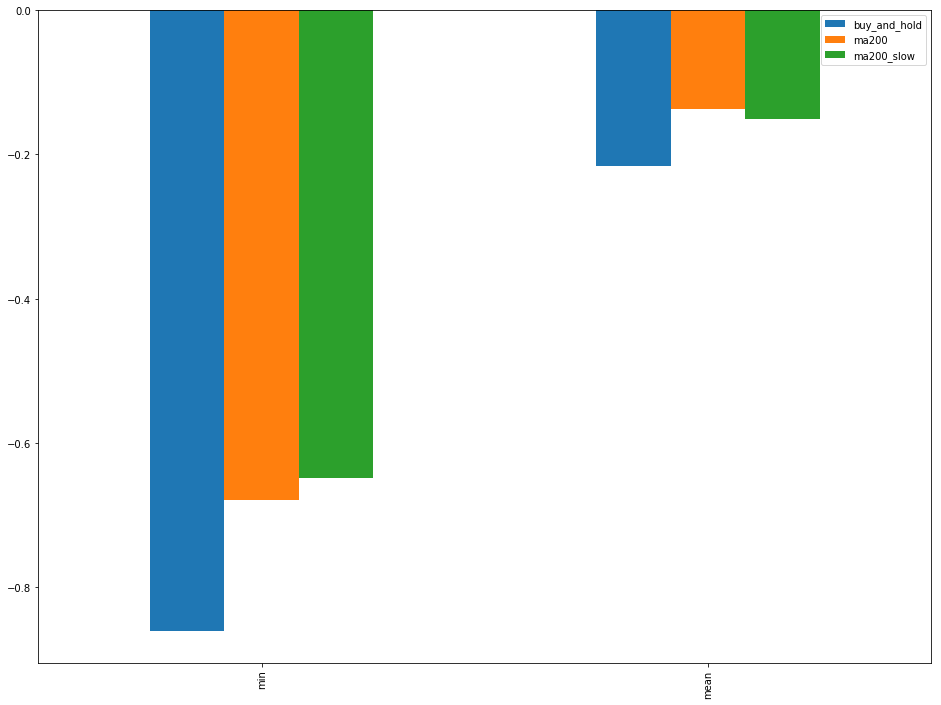

In [96]:
# Drawdowns
dd = (
    strats.mul(rets, axis=0)
    .add(1).cumprod()
    .transform(lambda xs: xs / xs.cummax() - 1)
)
dd_agg = dd.agg(['min', 'mean'])
print(dd_agg)
dd_agg.plot.bar()

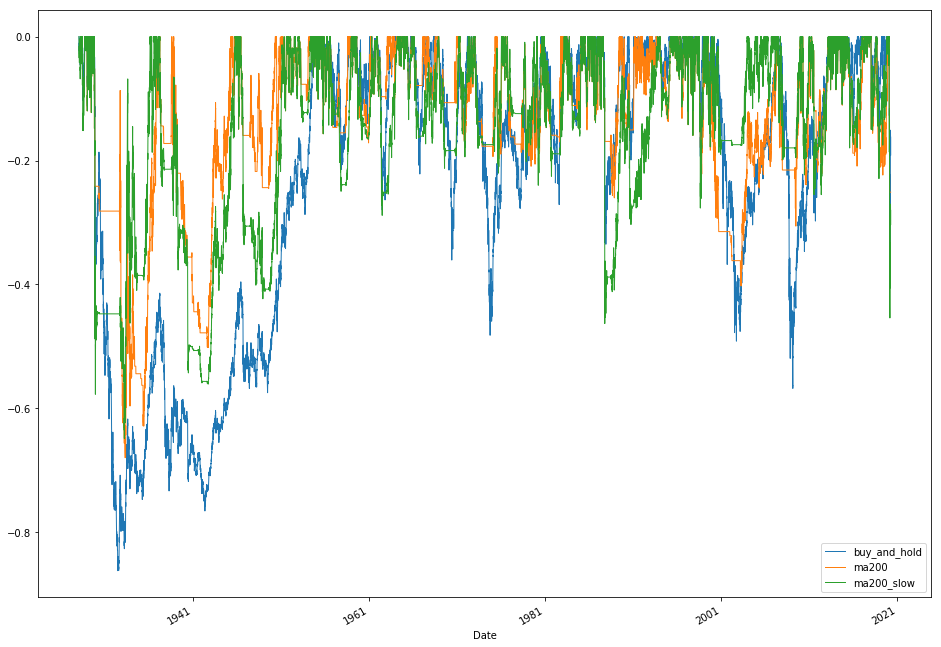

In [97]:
# Drawdowns side by side
dd.plot(lw=1)

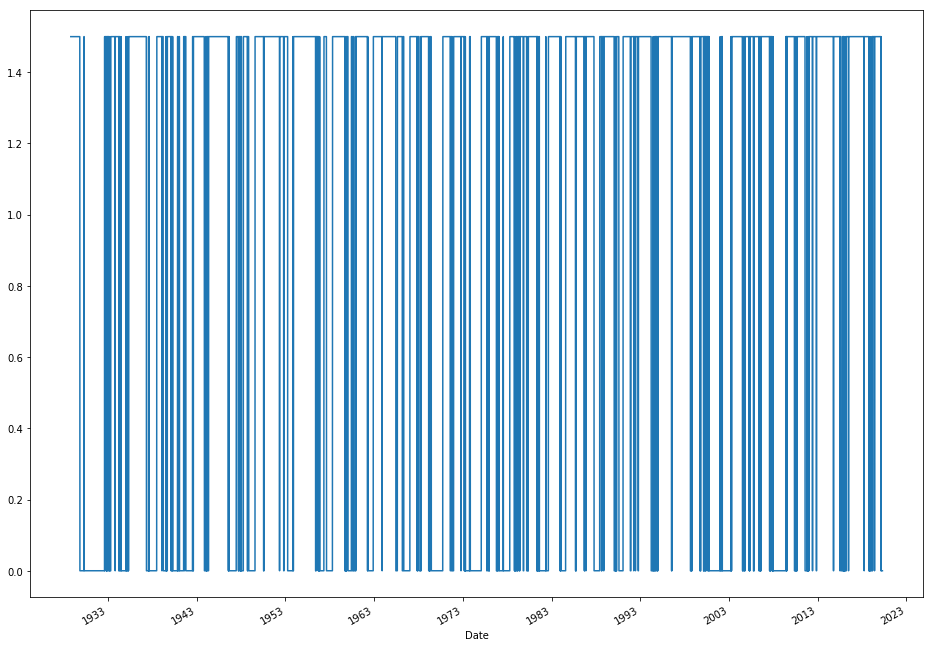

In [98]:
# Original signal slams on and off
strats.ma200.plot()

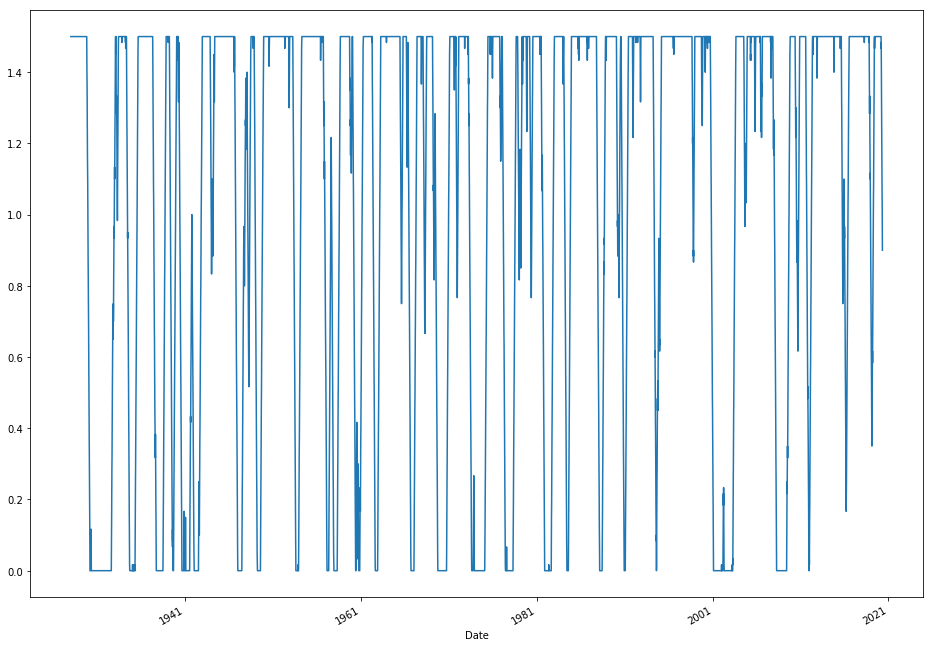

In [99]:
# New signal drifts in and out
strats.ma200_slow.plot()

In [100]:
# The original signal has trades on 4.2% of all days
strats.ma200.diff().ne(0).mean()

0.032516819044333276

In [101]:
# Smoothened signal trades (a much smaller amount in aggregate) on ~30% of all days
strats.ma200_slow.diff().ne(0).mean()

0.3234000345006038

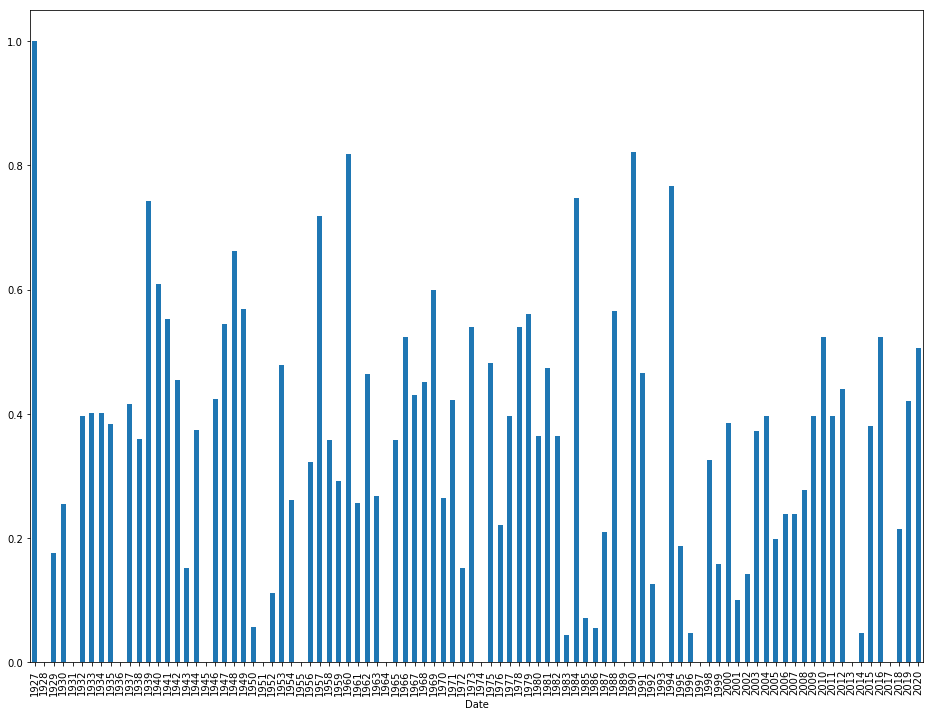

In [102]:
# Some years as many as 80% of all days
strats.ma200_slow.diff().ne(0).groupby(pd.Grouper(freq='Y')).mean().rename(index=lambda xs: xs.year).plot.bar()

In [103]:
# Account for how allocation drifts with return 
# f.(r + 1) / (f.r + 1)
pos_with_drift = (
    strats.shift().mul(rets + 1, axis=0)
    .div(strats.shift().mul(rets, axis=0).add(1), axis=0)
)
# Assume 20 bps transaction cost
costs = strats.sub(pos_with_drift).abs().mul(20. / 10000)

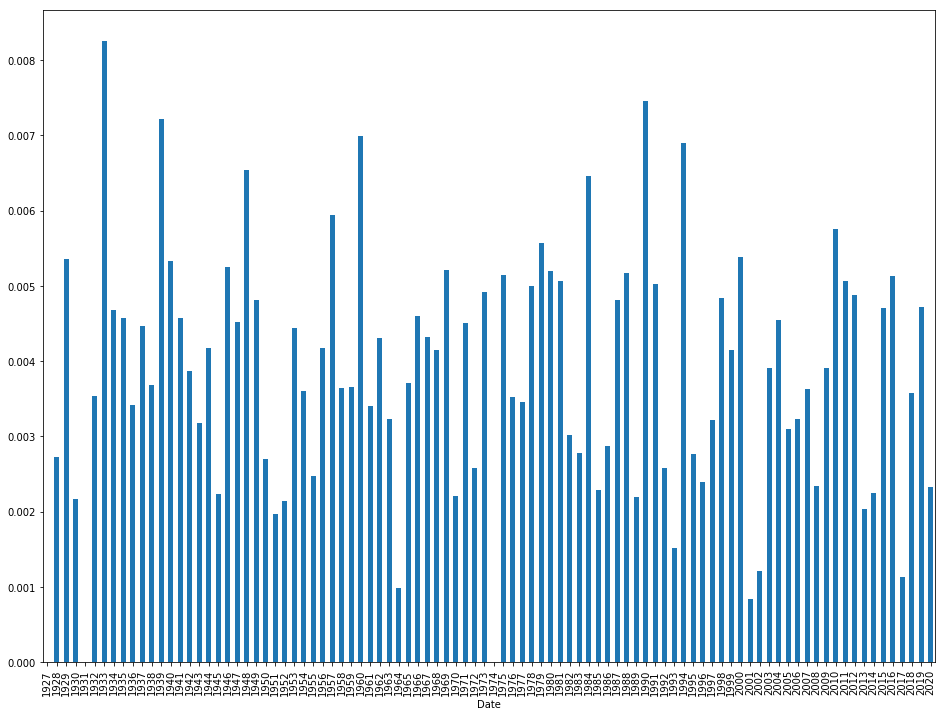

In [104]:
# Slow strategy costs at most 50 bps a year to execute
costs.ma200_slow.groupby(pd.Grouper(freq='Y')).sum().rename(index=lambda xs: xs.year).plot.bar()

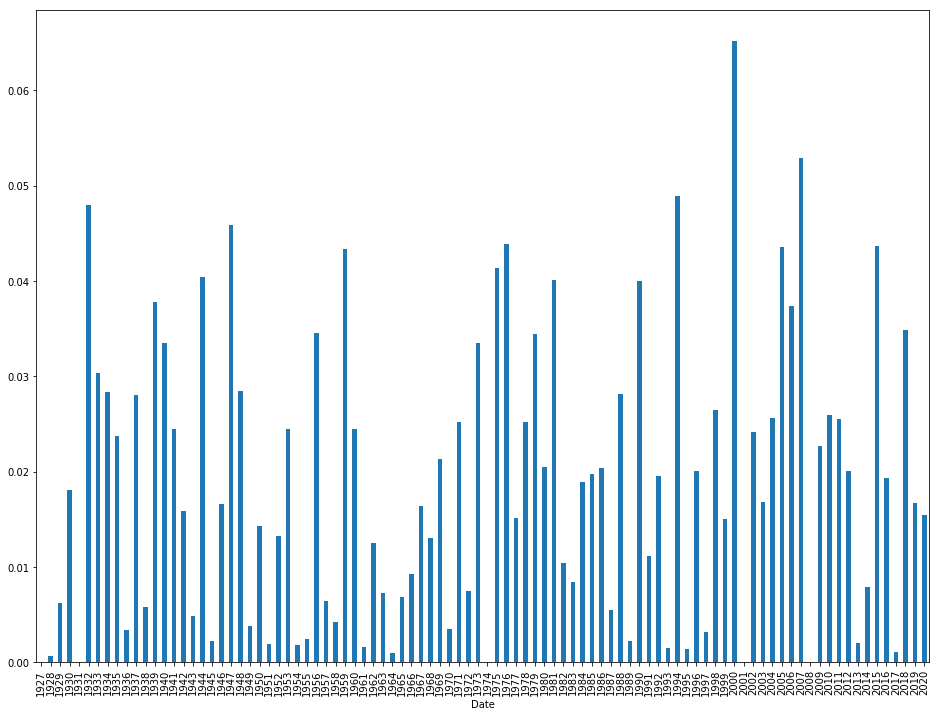

In [105]:
# Contrast with original signal - a few percent a year!
costs.ma200.groupby(pd.Grouper(freq='Y')).sum().rename(index=lambda xs: xs.year).plot.bar()

In [106]:
rets_after_costs = strats.mul(rets, axis=0) - costs

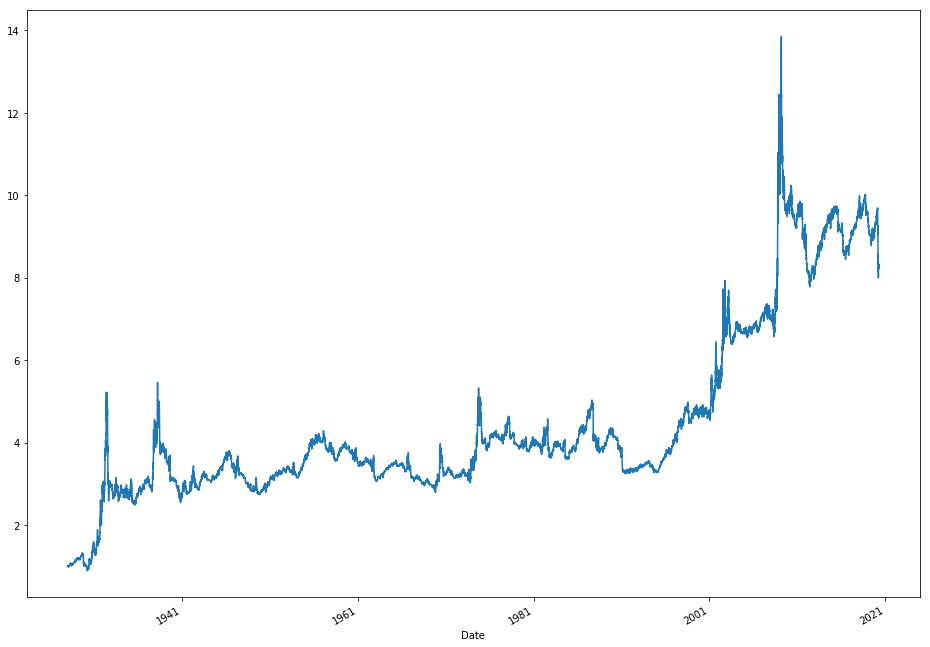

In [107]:
# Difference from buy and hold by year
(
    (rets_after_costs.ma200_slow + 1) 
    .div(rets_after_costs.buy_and_hold + 1)
    .cumprod().plot()
)

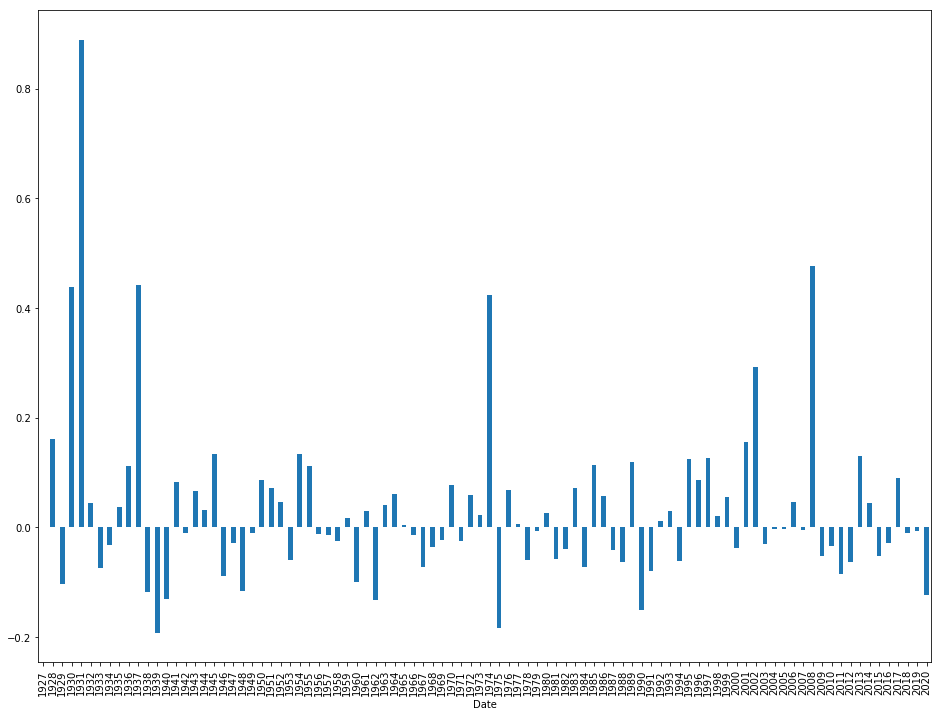

In [108]:
# Difference from buy and hold by year
(
    (rets_after_costs.ma200_slow + 1) 
    .div(rets_after_costs.buy_and_hold + 1)
    .groupby(pd.Grouper(freq='Y')).prod().sub(1)
    .rename(index=lambda xs: xs.year).plot.bar()
)

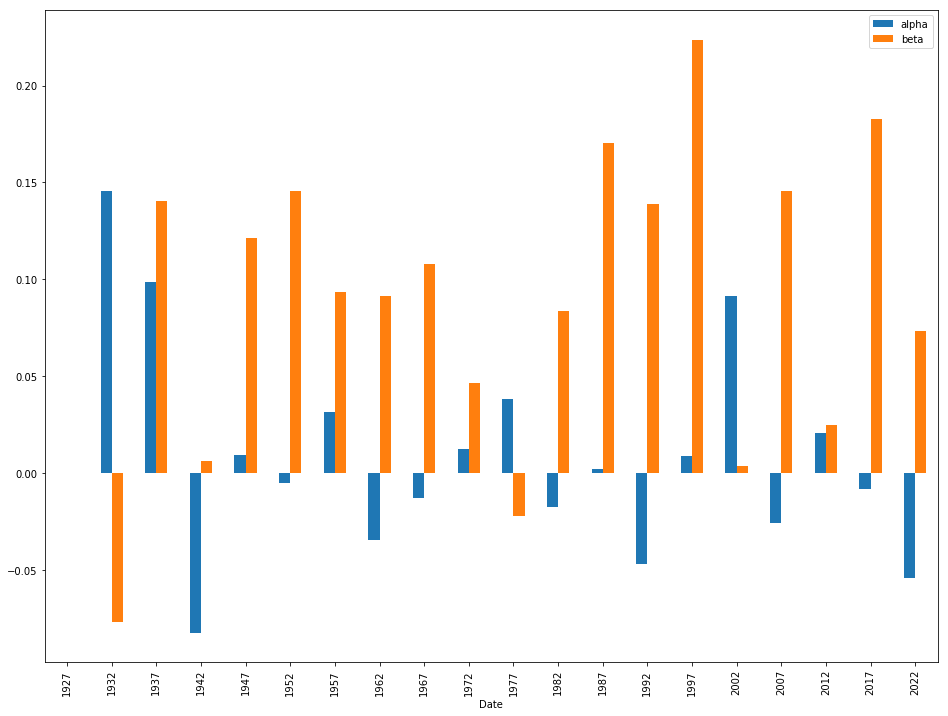

In [109]:
# Pretty much no alpha! This is just risk management.
(
    pd.concat([strats.ma200_slow.rename('pos'), rets], axis=1)
    .assign(strat_rets=lambda df: df.pos * df.rets)
    .groupby(pd.Grouper(freq='5Y'))
    .mean()
    .assign(
        beta=lambda df: df.pos * df.rets, 
        alpha=lambda df: df.strat_rets - df.beta
    ).mul(250)
    [['alpha', 'beta']]
    .rename(index=lambda xs: xs.year).plot.bar()
)

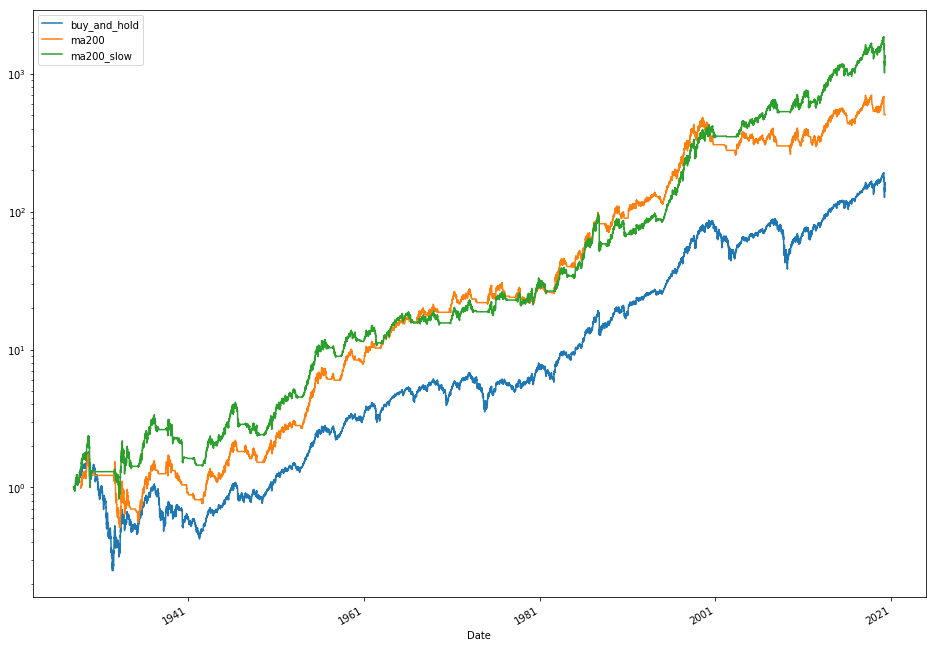

In [110]:
# Side by side, with transaction costs
rets_after_costs.add(1).cumprod().plot(logy=True)

In [111]:
# Sharpe ratios
rets_after_costs.agg(lambda xs: xs.mean() / xs.std() * 250**0.5)

buy_and_hold    0.383847
ma200           0.463538
ma200_slow      0.495437
dtype: float64